# Using AWS Lambda and PyWren to make HTTP Requests in Parallel

A common task for computational social scientists is making HTTP requests to access and process web data. It can be quite limiting to make these requests serially, though. When we do, the amount of data we are able to collect is limited both by our internet bandwidth and machine's ability to sequentially process the data.

It would be much better to parallelize this workflow. In this notebook, we're going to walk through how we can make API requests and perform simple calculations on text data in parallel using AWS Lambda and PyWren. Specifically, we will call the [Google Books API](https://developers.google.com/books/docs/v1/getting_started) in parallel on a list of ISBNs, calculating the number of words used in the description for each book in our ISBN list (see workflow below). Word count is a simple metric (used here as a proof-of-concept), but it would also be possible to perform other Natural Language Processing routines using this same approach. Such a cloud workflow allows us to gather and process far greater amounts of data than would be otherwise possible on our local machines.

![AWS Serverless Workflow](pywren_workflow.png)

If you haven't already, please [install/configure PyWren](http://pywren.io/pages/gettingstarted.html) in order to run this notebook. Then, let's import our packages and read in the list of ISBN numbers we'll be working with in this notebook:

In [2]:
!pip install matplotlib

  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [3]:
import pywren
import requests
import time
import matplotlib.pyplot as plt

with open('isbn.txt') as file:
    isbn_list = [isbn.strip() for isbn in file]

In [4]:
print("# of ISBNs in list:", len(isbn_list))

# of ISBNs in list: 500


We can specify search terms to return metadata from the Google Books dataset by entering a query string after the ?q= string in the API URL. For instance, we could specify an individual ISBN number for a book, like so:

In [5]:
url = "https://www.googleapis.com/books/v1/volumes?q=isbn:"
print(url + isbn_list[0])

https://www.googleapis.com/books/v1/volumes?q=isbn:0435910108


This will return the metadata for a single book:

In [6]:
r = requests.get(url + isbn_list[50])
data = r.json()
data

{'kind': 'books#volumes',
 'totalItems': 1,
 'items': [{'kind': 'books#volume',
   'id': 'DGALPwfF9fAC',
   'etag': 'h7I00Ttkiz4',
   'selfLink': 'https://www.googleapis.com/books/v1/volumes/DGALPwfF9fAC',
   'volumeInfo': {'title': 'The Best American Essays of the Century',
    'authors': ['Joyce Carol Oates', 'Robert Atwan'],
    'publisher': 'Mariner Books',
    'publishedDate': '2000',
    'description': 'An anthology of fifty-five essays on a variety of topics features contributions by F. Scott Fitzgerald, James Baldwin, Stephen Jay Gould, Alice Walker, Maya Angelou, and other notable twentieth-century literary masters.',
    'industryIdentifiers': [{'type': 'ISBN_10', 'identifier': '0618155872'},
     {'type': 'ISBN_13', 'identifier': '9780618155873'}],
    'readingModes': {'text': False, 'image': False},
    'pageCount': 596,
    'printType': 'BOOK',
    'categories': ['Literary Collections'],
    'averageRating': 4,
    'ratingsCount': 1,
    'maturityRating': 'NOT_MATURE',
   

Once we have this data, we can compute metrics based on it, such as determining the number of words in a given book's description:

In [7]:
description = data['items'][0]['volumeInfo']['description']
wc = len(description.split())
wc

31

Let's formalize this process so that we can determine the number of words that are in ***each*** description in a list of ISBN numbers:

In [8]:
def get_desc_wc(isbn_list):
    '''
    Takes in a list of ISBNs and returns a list of description
    word counts corresponding to each ISBN (via the Google
    Books API).
    '''
    wc_list = []
    for isbn in isbn_list:
        r = requests.get(url + isbn)
        data = r.json()
        # Try to get description, but if there is none, set
        # word count to be 0 for that book
        try:
            description = data['items'][0]['volumeInfo']['description']
            wc_list.append(len(description.split()))
        except KeyError:
            wc_list.append(0)
            pass
    return wc_list

We can then call our function and it will sequentially request information and calculate the description word count for each one of our ISBNs in the list:

Time elapsed (in seconds) - Serial:  163.1198649406433


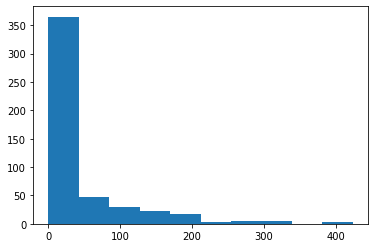

In [9]:
start = time.time()
wc_list = get_desc_wc(isbn_list)
time_elapsed = time.time() - start

print("Time elapsed (in seconds) - Serial: ", time_elapsed)

plt.hist(wc_list);

This is a bit slow (exactly how slow will be variable and heavily based on your internet connection!), though, and could benefit from parallelization. One way we can do this in a "serverless" fashion is by using PyWren to invoke AWS Lambda functions that make these ISBN API calls (and calculate the description word count) in parallel. To give each Lambda worker a single ISBN to work with, we can write another function that handles each ISBN individually:

In [10]:
def get_desc_wc_parallel(isbn):
    '''
    Takes in a single ISBN and returns a single description
    word count corresponding to the input ISBN (via the Google
    Books API).
    '''
    wc = 0
    r = requests.get(url + isbn)
    data = r.json()
    try:
        description = data['items'][0]['volumeInfo']['description']
        wc = len(description.split())
    except KeyError:
        pass
    return wc

And we can then use PyWren and AWS Lambda to remotely execute this function on each ISBN in our ISBN list in parallel:

In [11]:
pwex = pywren.default_executor()
start = time.time()

# Apply get_desc_wc to list of ISBNs, which will automatically be remotely executed by AWS Lambda in parallel
futures = pwex.map(get_desc_wc_parallel, isbn_list)

# get_all_results waits until all of the futures have been executed and then returns their results
# note that this is an alternative to the list comprehension in the lecture video
wc_list = pywren.get_all_results(futures)

time_elapsed = time.time() - start

print("Time elapsed (in seconds) - AWS Lambda Solution", time_elapsed)

Time elapsed (in seconds) - AWS Lambda Solution 45.47473740577698


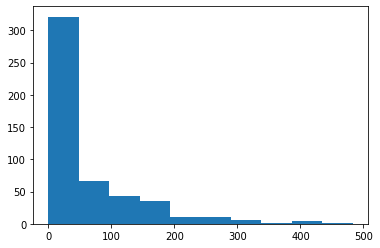

In [12]:
plt.hist(wc_list); # should mirror plot derived from serial execution

If we plot the results that PyWren has given us (see above), we can see that we have the same result, but it takes a lot less time to execute when we make API calls in parallel, even accounting for all of the communications between us and AWS and time spent invoking and setting up our Lambda workers. 

This means that we should be able to gather a lot more data than we would be capable of gathering serially!

So, let's say that we had 2000 ISBNs instead of just 500. We can simulate this by extending our list with copies of the existing ISBNs and then rerunning our code with this new data size:

In [13]:
isbn_list = isbn_list * 4

start = time.time()
wc_list = get_desc_wc(isbn_list)
time_elapsed = time.time() - start

print("Time elapsed (in seconds) - Serial: ", time_elapsed)

Time elapsed (in seconds) - Serial:  534.3644404411316


So, operating serially, this would take us awhile to perform all of these API calls (again, depending on your machine and internet connection). What about in parallel with Lambda and PyWren?

In [14]:
start = time.time()

# Apply get_desc_wc to list of ISBNs, which will automatically be remotely executed by AWS Lambda in parallel
futures = pwex.map(get_desc_wc_parallel, isbn_list)

# get_all_results waits until all of the futures have been executed and then returns their results
# note that this is an alternative to the list comprehension in the lecture video
wc_list = pywren.get_all_results(futures)

time_elapsed = time.time() - start

print("Time elapsed (in seconds) - AWS Lambda Solution", time_elapsed)

Time elapsed (in seconds) - AWS Lambda Solution 74.38310098648071


We're around 5-10x faster than serial. Currently, though, note that we're invoking a devoted Lambda function instance to request metadata ***for each*** of our ISBNs. Imagine, though, that we have 6000 ISBNs that we want to process in parallel. This will exceed the [maximum of number of concurrent Lambda workers (3000)](https://docs.aws.amazon.com/lambda/latest/dg/invocation-scaling.html) and, thus, our scaling capabilities will be limited:

In [15]:
isbn_list = isbn_list * 3 # 6000 ISBNs
start = time.time()

# Apply get_desc_wc to list of ISBNs, which will automatically be remotely executed by AWS Lambda in parallel
futures = pwex.map(get_desc_wc_parallel, isbn_list)

# get_all_results waits until all of the futures have been executed and then returns their results
# note that this is an alternative to the list comprehension in the lecture video
wc_list = pywren.get_all_results(futures)

time_elapsed = time.time() - start

print("Time elapsed (in seconds) - AWS Lambda Solution", time_elapsed)

Time elapsed (in seconds) - AWS Lambda Solution 216.64267873764038


One way to get around this with PyWren is to make ***multiple API requests on a single set of 3000 simultaneous Lambda workers*** that we have already invoked to perform the first round of API requests. These requests do not take much time to perform on their own and can be performed concurrently. So, for instance, we might construct batch sizes of 2 ISBNs for each Lambda function to request information about and process (spread across 3000 parallel Lambda functions):

In [16]:
n = 2 # subdivide list of ISBNs into batches of size 2
isbn_batches = [isbn_list[i:i + n] for i in range(0, len(isbn_list), n)]
print(len(isbn_batches), len(isbn_batches[0]))

3000 2


In [17]:
start = time.time()

# Apply get_desc_wc to list of ISBNs, which will automatically be remotely executed by AWS Lambda in parallel
# each invocation of get_desc_wc is passed a length-2 list of ISBNs
futures = pwex.map(get_desc_wc, isbn_batches)

# get_all_results waits until all of the futures have been executed and then returns their results
# will return list of length-2 lists -- need to flatten this for further processing
wc_list = pywren.get_all_results(futures) 

time_elapsed = time.time() - start

print("Time elapsed (in seconds) - AWS Lambda Solution", time_elapsed)

Time elapsed (in seconds) - AWS Lambda Solution 109.64466261863708


Much better! By constructing mini-batches of our ISBNs, we maximize the use of the lambda workers that we have invoked without needing to invoke and set up another set of workers, as in our initial PyWren solution above. This is also a fairly scalable solution --  as we increase our data size, we will continue to see our parallel solution improve upon our serial one (so long as we don't go beyond the maximum Lambda timeout window for each Lambda worker).